In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '.\\data\\dice\\'
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128
batch_size = 128
channel_nb = 3 # Numbers of color channels (3 for RGB)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

## Functions

In [3]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

## Init Cuda

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
device

device(type='cuda')

In [6]:
train_dl = DeviceDataLoader(train_dl, device)

## Generator

In [7]:
generator = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
    nn.BatchNorm2d(ngf * 16),
    nn.ReLU(True),
    # state size. (ngf*16) x 4 x 4
    nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 8 x 8
    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 4),
    nn.ReLU(True),
    # state size. (ngf*4) x 16 x 16 
    nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 2),
    nn.ReLU(True),
    # state size. (ngf*2) x 32 x 32
    nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),
    # state size. (ngf) x 64 x 64
    nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
    nn.Tanh()
    # state size. (nc) x 128 x 128
)

### Send Generator to GPU

In [8]:
generator = to_device(generator, device)

## Discriminator

In [9]:
discriminator = nn.Sequential(
    # input is (nc) x 128 x 128
    nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf) x 64 x 64
    nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 32 x 32
    nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 16 x 16 
    nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 8 x 8
    nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf * 16),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*16) x 4 x 4
    nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
    # state size. 1
)

## Send Discriminator to GPU

In [10]:
discriminator = to_device(discriminator, device)

## Saving
Saves the generated picture after every epoch

In [11]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

## Training

### Discriminator

In [12]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    loss = nn.BCELoss()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = loss(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    train_loss = real_loss + fake_loss
    train_loss.backward()
    opt_d.step()
    return train_loss.item(), real_score, fake_score

### Generator

In [13]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    loss = nn.BCELoss()
    
    # Generate fake images
    latent = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    gen_loss = loss(preds, targets)
    
    # Update generator weights
    gen_loss.backward()
    opt_g.step()
    
    return gen_loss.item()

### Fit
Function to train the Discriminator and Generator

In [14]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [15]:
lr = 0.0002
epochs = 128
fixed_latent = torch.randn(64, nz, 1, 1, device=device)
history = fit(epochs, lr)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/128], loss_g: 8.4252, loss_d: 0.0082, real_score: 0.9943, fake_score: 0.0014
Saving generated-images-0001.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/128], loss_g: 16.0317, loss_d: 0.0008, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0002.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/128], loss_g: 10.1548, loss_d: 0.0019, real_score: 0.9989, fake_score: 0.0008
Saving generated-images-0003.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/128], loss_g: 27.4888, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0004.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/128], loss_g: 13.3982, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/128], loss_g: 10.0116, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0006.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/128], loss_g: 9.0361, loss_d: 0.0010, real_score: 0.9996, fake_score: 0.0006
Saving generated-images-0007.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/128], loss_g: 7.7120, loss_d: 0.0339, real_score: 1.0000, fake_score: 0.0331
Saving generated-images-0008.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/128], loss_g: 0.0066, loss_d: 1.7625, real_score: 0.3058, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/128], loss_g: 18.5735, loss_d: 0.3709, real_score: 1.0000, fake_score: 0.2701
Saving generated-images-0010.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/128], loss_g: 28.8342, loss_d: 9.9946, real_score: 0.0002, fake_score: 0.0000
Saving generated-images-0011.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/128], loss_g: 8.5154, loss_d: 0.0399, real_score: 0.9637, fake_score: 0.0019
Saving generated-images-0012.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/128], loss_g: 7.0687, loss_d: 0.1227, real_score: 0.9664, fake_score: 0.0811
Saving generated-images-0013.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/128], loss_g: 5.9232, loss_d: 0.0217, real_score: 0.9817, fake_score: 0.0028
Saving generated-images-0014.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/128], loss_g: 7.0261, loss_d: 0.9806, real_score: 0.8418, fake_score: 0.4113
Saving generated-images-0015.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/128], loss_g: 6.3598, loss_d: 0.0419, real_score: 0.9837, fake_score: 0.0225
Saving generated-images-0016.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/128], loss_g: 2.3678, loss_d: 0.1086, real_score: 0.9972, fake_score: 0.0940
Saving generated-images-0017.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/128], loss_g: 6.6935, loss_d: 0.1450, real_score: 0.9346, fake_score: 0.0591
Saving generated-images-0018.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/128], loss_g: 5.0054, loss_d: 0.0119, real_score: 0.9981, fake_score: 0.0099
Saving generated-images-0019.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/128], loss_g: 10.1550, loss_d: 0.0066, real_score: 0.9935, fake_score: 0.0001
Saving generated-images-0020.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/128], loss_g: 3.2094, loss_d: 0.3340, real_score: 0.7479, fake_score: 0.0013
Saving generated-images-0021.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/128], loss_g: 5.8878, loss_d: 0.0102, real_score: 0.9969, fake_score: 0.0070
Saving generated-images-0022.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/128], loss_g: 2.5350, loss_d: 2.8191, real_score: 0.9917, fake_score: 0.8427
Saving generated-images-0023.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/128], loss_g: 3.9826, loss_d: 0.1789, real_score: 0.9387, fake_score: 0.1057
Saving generated-images-0024.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/128], loss_g: 4.8425, loss_d: 2.3803, real_score: 0.1702, fake_score: 0.0015
Saving generated-images-0025.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/128], loss_g: 1.8438, loss_d: 0.5199, real_score: 0.8851, fake_score: 0.2816
Saving generated-images-0026.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/128], loss_g: 0.5862, loss_d: 0.4320, real_score: 0.8705, fake_score: 0.2367
Saving generated-images-0027.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/128], loss_g: 1.1812, loss_d: 0.8183, real_score: 0.5234, fake_score: 0.0682
Saving generated-images-0028.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/128], loss_g: 3.2830, loss_d: 0.5577, real_score: 0.9257, fake_score: 0.3586
Saving generated-images-0029.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/128], loss_g: 2.1318, loss_d: 0.5823, real_score: 0.6899, fake_score: 0.1538
Saving generated-images-0030.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/128], loss_g: 1.7311, loss_d: 1.0950, real_score: 0.8904, fake_score: 0.5426
Saving generated-images-0031.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/128], loss_g: 3.0928, loss_d: 0.5479, real_score: 0.8443, fake_score: 0.2896
Saving generated-images-0032.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/128], loss_g: 1.0447, loss_d: 0.7645, real_score: 0.5263, fake_score: 0.0770
Saving generated-images-0033.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/128], loss_g: 2.0759, loss_d: 0.7786, real_score: 0.6904, fake_score: 0.3091
Saving generated-images-0034.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/128], loss_g: 2.7969, loss_d: 0.7011, real_score: 0.8897, fake_score: 0.4233
Saving generated-images-0035.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/128], loss_g: 2.4894, loss_d: 0.5781, real_score: 0.8284, fake_score: 0.2997
Saving generated-images-0036.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/128], loss_g: 3.2896, loss_d: 0.7264, real_score: 0.9403, fake_score: 0.4516
Saving generated-images-0037.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/128], loss_g: 3.7806, loss_d: 0.4260, real_score: 0.8407, fake_score: 0.2070
Saving generated-images-0038.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/128], loss_g: 3.2441, loss_d: 0.1020, real_score: 0.9804, fake_score: 0.0767
Saving generated-images-0039.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/128], loss_g: 1.5490, loss_d: 1.1714, real_score: 0.5370, fake_score: 0.3707
Saving generated-images-0040.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [41/128], loss_g: 3.1490, loss_d: 1.2584, real_score: 0.8978, fake_score: 0.6638
Saving generated-images-0041.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [42/128], loss_g: 0.7177, loss_d: 1.2486, real_score: 0.3483, fake_score: 0.1006
Saving generated-images-0042.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [43/128], loss_g: 0.9046, loss_d: 1.1142, real_score: 0.3569, fake_score: 0.0468
Saving generated-images-0043.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [44/128], loss_g: 1.9384, loss_d: 0.3392, real_score: 0.7401, fake_score: 0.0316
Saving generated-images-0044.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [45/128], loss_g: 3.9133, loss_d: 0.9954, real_score: 0.9403, fake_score: 0.5539
Saving generated-images-0045.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [46/128], loss_g: 1.5731, loss_d: 0.5484, real_score: 0.6085, fake_score: 0.0349
Saving generated-images-0046.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [47/128], loss_g: 1.8541, loss_d: 0.8164, real_score: 0.5166, fake_score: 0.0810
Saving generated-images-0047.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [48/128], loss_g: 2.9063, loss_d: 0.4838, real_score: 0.8548, fake_score: 0.2636
Saving generated-images-0048.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [49/128], loss_g: 2.9130, loss_d: 0.8279, real_score: 0.9305, fake_score: 0.4882
Saving generated-images-0049.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [50/128], loss_g: 1.8404, loss_d: 0.4757, real_score: 0.8341, fake_score: 0.2339
Saving generated-images-0050.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [51/128], loss_g: 2.7858, loss_d: 0.2682, real_score: 0.8180, fake_score: 0.0578
Saving generated-images-0051.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [52/128], loss_g: 6.7778, loss_d: 0.3755, real_score: 0.9644, fake_score: 0.2681
Saving generated-images-0052.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [53/128], loss_g: 1.1705, loss_d: 0.9846, real_score: 0.6111, fake_score: 0.3301
Saving generated-images-0053.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [54/128], loss_g: 1.7072, loss_d: 0.7390, real_score: 0.6830, fake_score: 0.2725
Saving generated-images-0054.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [55/128], loss_g: 2.7412, loss_d: 0.8280, real_score: 0.8751, fake_score: 0.4648
Saving generated-images-0055.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [56/128], loss_g: 1.8473, loss_d: 0.7412, real_score: 0.9297, fake_score: 0.4404
Saving generated-images-0056.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [57/128], loss_g: 2.0070, loss_d: 0.4468, real_score: 0.6938, fake_score: 0.0553
Saving generated-images-0057.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [58/128], loss_g: 2.7053, loss_d: 0.3200, real_score: 0.9046, fake_score: 0.1882
Saving generated-images-0058.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [59/128], loss_g: 2.0052, loss_d: 1.9454, real_score: 0.1698, fake_score: 0.0027
Saving generated-images-0059.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [60/128], loss_g: 1.3754, loss_d: 0.6355, real_score: 0.6143, fake_score: 0.0839
Saving generated-images-0060.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [61/128], loss_g: 4.4357, loss_d: 0.2392, real_score: 0.9656, fake_score: 0.1705
Saving generated-images-0061.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [62/128], loss_g: 4.1768, loss_d: 0.1900, real_score: 0.9183, fake_score: 0.0966
Saving generated-images-0062.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [63/128], loss_g: 4.7054, loss_d: 0.0799, real_score: 0.9938, fake_score: 0.0687
Saving generated-images-0063.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [64/128], loss_g: 6.5421, loss_d: 0.0342, real_score: 0.9987, fake_score: 0.0319
Saving generated-images-0064.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [65/128], loss_g: 16.9205, loss_d: 0.3104, real_score: 0.9999, fake_score: 0.2521
Saving generated-images-0065.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [66/128], loss_g: 15.5927, loss_d: 0.0039, real_score: 0.9961, fake_score: 0.0000
Saving generated-images-0066.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [67/128], loss_g: 13.9341, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0067.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [68/128], loss_g: 6.4169, loss_d: 0.0098, real_score: 0.9971, fake_score: 0.0068
Saving generated-images-0068.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [69/128], loss_g: 6.3155, loss_d: 0.0099, real_score: 0.9964, fake_score: 0.0061
Saving generated-images-0069.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [70/128], loss_g: 7.9594, loss_d: 0.0058, real_score: 0.9970, fake_score: 0.0028
Saving generated-images-0070.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [71/128], loss_g: 12.3727, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0071.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [72/128], loss_g: 16.6365, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0072.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [73/128], loss_g: 12.3589, loss_d: 0.0027, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-0073.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [74/128], loss_g: 7.3729, loss_d: 0.0140, real_score: 0.9952, fake_score: 0.0090
Saving generated-images-0074.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [75/128], loss_g: 10.0454, loss_d: 0.0149, real_score: 0.9855, fake_score: 0.0001
Saving generated-images-0075.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [76/128], loss_g: 26.8737, loss_d: 21.4421, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0076.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [77/128], loss_g: 2.6172, loss_d: 1.3524, real_score: 0.5216, fake_score: 0.1874
Saving generated-images-0077.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [78/128], loss_g: 2.0945, loss_d: 0.5123, real_score: 0.8137, fake_score: 0.2379
Saving generated-images-0078.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [79/128], loss_g: 1.8197, loss_d: 1.0443, real_score: 0.4994, fake_score: 0.0652
Saving generated-images-0079.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [80/128], loss_g: 1.4656, loss_d: 0.6063, real_score: 0.6104, fake_score: 0.0710
Saving generated-images-0080.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [81/128], loss_g: 3.8589, loss_d: 0.3698, real_score: 0.8515, fake_score: 0.1748
Saving generated-images-0081.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [82/128], loss_g: 2.0221, loss_d: 0.7687, real_score: 0.9016, fake_score: 0.4475
Saving generated-images-0082.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [83/128], loss_g: 0.4727, loss_d: 0.9994, real_score: 0.4370, fake_score: 0.0535
Saving generated-images-0083.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [84/128], loss_g: 2.9789, loss_d: 0.3183, real_score: 0.8350, fake_score: 0.1209
Saving generated-images-0084.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [85/128], loss_g: 1.6108, loss_d: 0.6550, real_score: 0.6392, fake_score: 0.1082
Saving generated-images-0085.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [86/128], loss_g: 2.0636, loss_d: 0.4637, real_score: 0.6457, fake_score: 0.0065
Saving generated-images-0086.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [87/128], loss_g: 2.6374, loss_d: 0.5172, real_score: 0.7950, fake_score: 0.2326
Saving generated-images-0087.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [88/128], loss_g: 3.0304, loss_d: 0.3715, real_score: 0.8670, fake_score: 0.1927
Saving generated-images-0088.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [89/128], loss_g: 3.8479, loss_d: 0.0862, real_score: 0.9704, fake_score: 0.0535
Saving generated-images-0089.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [90/128], loss_g: 1.4332, loss_d: 0.5521, real_score: 0.7808, fake_score: 0.2379
Saving generated-images-0090.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [91/128], loss_g: 4.6144, loss_d: 1.1344, real_score: 0.9803, fake_score: 0.6126
Saving generated-images-0091.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [92/128], loss_g: 3.5021, loss_d: 0.1542, real_score: 0.9171, fake_score: 0.0624
Saving generated-images-0092.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [93/128], loss_g: 1.1473, loss_d: 1.6068, real_score: 0.3171, fake_score: 0.0085
Saving generated-images-0093.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [94/128], loss_g: 1.8712, loss_d: 0.6489, real_score: 0.6846, fake_score: 0.2125
Saving generated-images-0094.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [95/128], loss_g: 2.4812, loss_d: 0.3293, real_score: 0.8381, fake_score: 0.1334
Saving generated-images-0095.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [96/128], loss_g: 3.2927, loss_d: 0.2061, real_score: 0.9456, fake_score: 0.1325
Saving generated-images-0096.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [97/128], loss_g: 0.9937, loss_d: 0.4613, real_score: 0.7661, fake_score: 0.1430
Saving generated-images-0097.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [98/128], loss_g: 4.1744, loss_d: 0.4989, real_score: 0.9460, fake_score: 0.3157
Saving generated-images-0098.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [99/128], loss_g: 4.0266, loss_d: 0.1154, real_score: 0.9269, fake_score: 0.0367
Saving generated-images-0099.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [100/128], loss_g: 6.0574, loss_d: 0.0913, real_score: 0.9257, fake_score: 0.0097
Saving generated-images-0100.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [101/128], loss_g: 3.4162, loss_d: 0.1925, real_score: 0.8481, fake_score: 0.0146
Saving generated-images-0101.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [102/128], loss_g: 4.9987, loss_d: 0.0260, real_score: 0.9921, fake_score: 0.0177
Saving generated-images-0102.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [103/128], loss_g: 4.4493, loss_d: 0.0352, real_score: 0.9817, fake_score: 0.0163
Saving generated-images-0103.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [104/128], loss_g: 4.0572, loss_d: 0.0447, real_score: 0.9902, fake_score: 0.0335
Saving generated-images-0104.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [105/128], loss_g: 5.0152, loss_d: 0.0361, real_score: 0.9718, fake_score: 0.0072
Saving generated-images-0105.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [106/128], loss_g: 5.2975, loss_d: 0.0319, real_score: 0.9755, fake_score: 0.0065
Saving generated-images-0106.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [107/128], loss_g: 4.7905, loss_d: 1.5262, real_score: 0.7069, fake_score: 0.3901
Saving generated-images-0107.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [108/128], loss_g: 2.8117, loss_d: 0.6984, real_score: 0.8109, fake_score: 0.3402
Saving generated-images-0108.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [109/128], loss_g: 2.1745, loss_d: 0.4820, real_score: 0.7272, fake_score: 0.1297
Saving generated-images-0109.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [110/128], loss_g: 1.7599, loss_d: 0.4495, real_score: 0.6996, fake_score: 0.0746
Saving generated-images-0110.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [111/128], loss_g: 3.5239, loss_d: 0.7305, real_score: 0.9730, fake_score: 0.4583
Saving generated-images-0111.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [112/128], loss_g: 3.2786, loss_d: 0.1456, real_score: 0.9304, fake_score: 0.0671
Saving generated-images-0112.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [113/128], loss_g: 4.3579, loss_d: 0.1092, real_score: 0.9311, fake_score: 0.0319
Saving generated-images-0113.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [114/128], loss_g: 5.7876, loss_d: 0.3159, real_score: 0.9843, fake_score: 0.2286
Saving generated-images-0114.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [115/128], loss_g: 2.9975, loss_d: 0.1270, real_score: 0.9270, fake_score: 0.0476
Saving generated-images-0115.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [116/128], loss_g: 4.1862, loss_d: 0.0935, real_score: 0.9595, fake_score: 0.0483
Saving generated-images-0116.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [117/128], loss_g: 4.7208, loss_d: 0.0875, real_score: 0.9293, fake_score: 0.0121
Saving generated-images-0117.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [118/128], loss_g: 16.9442, loss_d: 1.9704, real_score: 0.9963, fake_score: 0.6851
Saving generated-images-0118.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [119/128], loss_g: 3.0073, loss_d: 0.7251, real_score: 0.8643, fake_score: 0.4057
Saving generated-images-0119.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [120/128], loss_g: 3.6167, loss_d: 0.5704, real_score: 0.8823, fake_score: 0.3081
Saving generated-images-0120.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [121/128], loss_g: 2.7226, loss_d: 0.1987, real_score: 0.8853, fake_score: 0.0688
Saving generated-images-0121.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [122/128], loss_g: 5.1827, loss_d: 0.1349, real_score: 0.9555, fake_score: 0.0808
Saving generated-images-0122.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [123/128], loss_g: 3.4571, loss_d: 0.1335, real_score: 0.9171, fake_score: 0.0418
Saving generated-images-0123.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [124/128], loss_g: 4.5268, loss_d: 0.0773, real_score: 0.9647, fake_score: 0.0390
Saving generated-images-0124.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [125/128], loss_g: 4.9926, loss_d: 0.0524, real_score: 0.9602, fake_score: 0.0109
Saving generated-images-0125.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [126/128], loss_g: 5.3334, loss_d: 0.0429, real_score: 0.9836, fake_score: 0.0254
Saving generated-images-0126.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [127/128], loss_g: 5.2316, loss_d: 0.0399, real_score: 0.9872, fake_score: 0.0259
Saving generated-images-0127.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [128/128], loss_g: 4.5016, loss_d: 0.0303, real_score: 0.9902, fake_score: 0.0198
Saving generated-images-0128.png


## Graph

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
losses = history[0:2]
scores = history[2:4]

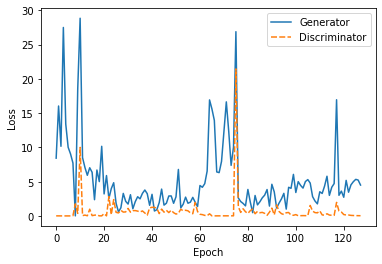

In [43]:
ax = sns.lineplot(data=losses)
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend(title=None, loc='upper right', labels=['Generator', 'Discriminator'])
plt.show()

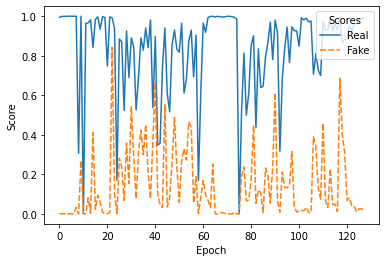

In [45]:
ax = sns.lineplot(data=scores)
ax.set(xlabel='Epoch', ylabel='Score')
plt.legend(title="Scores", loc='upper right', labels=['Real', 'Fake'])
plt.show()